# Natural Language Processing with Disaster Tweets

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

We are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.



## Exploratory Data Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Load datasets
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

In [4]:
train.info()
print(train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [14]:
for tweet, keyword in train[["text", "keyword"]].sample(7, random_state=42).values:
    print(tweet,"-", keyword)

So you have a new weapon that can cause un-imaginable destruction. - destruction
The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@ - deluge
DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q - police
Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night. - aftershock
in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3 - trauma
@Calum5SOS you look like you got caught in a rainstorm this is amazing and disgusting at the same time - rainstorm
my favorite lady came to our volunteer meeting
hopefully joining her youth collision and i am excite http://t.co/Ij0wQ490cS - collision


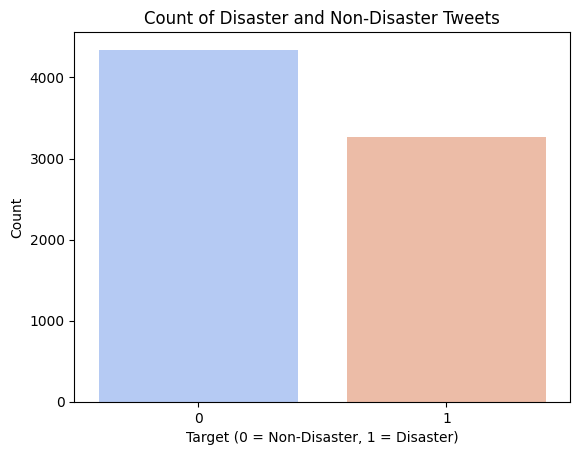

In [7]:
#check the balance between disaster tweet and others
sns.countplot(x='target', data=train)
plt.xlabel('Target (0 = Non-Disaster, 1 = Disaster)')
sns.countplot(x='target', data=train, palette='coolwarm', hue='target', legend=False)
plt.ylabel('Count')
plt.title('Count of Disaster and Non-Disaster Tweets')
plt.show()

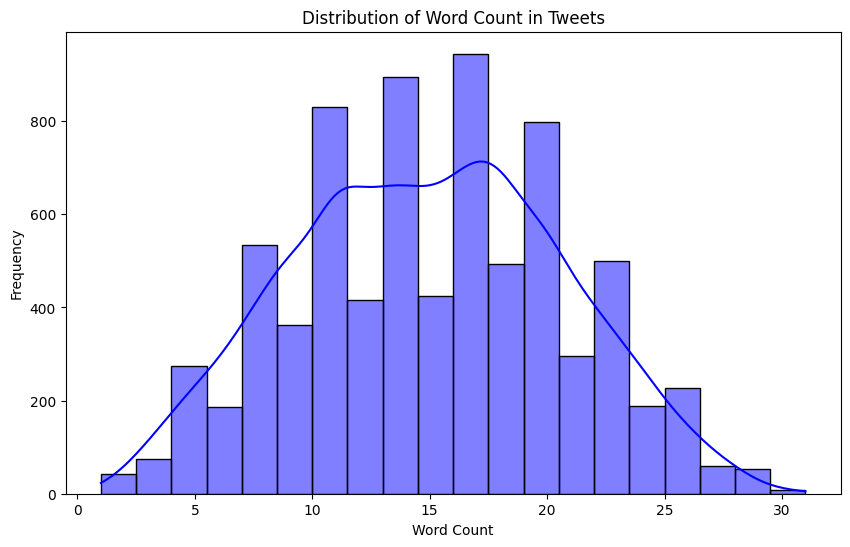

In [ ]:
#wordcount per tweets
copy_train = train.copy()
copy_train['word_count'] = copy_train['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(copy_train['word_count'], kde=True, bins=20, color='blue')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count in Tweets')
plt.show()

### Analysis
Each class has enough tweets so we don't need to balance the dataset. tweets lengths are between 1 and 30 words with most of them been between 10 and 20 words. We have 32% missing values on the "location" variable. Since we plan to use DistilBERT (which is the light version of BERT), we will focus on the text variable only.

## Preprocessing

In [15]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import re

# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to clean text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions (@username) and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'\W|[\d]', ' ', text)
    # Convert to lowercase
    text = text.lower().strip()
    return text

# Apply text cleaning
train['clean_text'] = train['text'].apply(clean_text)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train['clean_text'],  # Features: cleaned text
    train['target'],      # Labels: target column
    test_size=0.2,
    random_state=42
)

# Tokenize the cleaned text
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

# Tokenize the training and validation data
train_tokens = tokenize_texts(X_train, tokenizer)
val_tokens = tokenize_texts(X_val, tokenizer)

# Inspect tokenized output
print("Tokenized keys:", train_tokens.keys())  # 'input_ids' and 'attention_mask'
print("Example tokenized input IDs:", train_tokens['input_ids'][0])
print("Example tokenized attention mask:", train_tokens['attention_mask'][0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenized keys: dict_keys(['input_ids', 'attention_mask'])
Example tokenized input IDs: tensor([  101, 26103,  1998,  7481,  4106,  1997,  2342,  2000,  2224,  9593,
         5968,  1999,  2887,  2510,  4188,  7806,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     

## training : DistilBERT Model

In [16]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertForSequenceClassification, AdamW

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Custom Dataset class
class DisasterTweetsDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create datasets
train_dataset = DisasterTweetsDataset(train_tokens, y_train.tolist())
val_dataset = DisasterTweetsDataset(val_tokens, y_val.tolist())

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Load the DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)
model.to(device)

# Optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    train_loss = 0
    for batch in train_loader:
        # Move batch to device
        batch = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            # Move batch to device
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            val_loss += loss.item()

            # Predictions
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == batch["labels"]).sum().item()
            total += batch["labels"].size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

# Save the model
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/distilbert-disaster-tweets")
tokenizer.save_pretrained("/content/drive/MyDrive/Colab Notebooks/distilbert-disaster-tweets")

Device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-16-c2869b52ac94>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1/3
Average Training Loss: 0.4459
Validation Loss: 0.3964
Validation Accuracy: 0.8385
Epoch 2/3
Average Training Loss: 0.3075
Validation Loss: 0.4999
Validation Accuracy: 0.8070
Epoch 3/3
Average Training Loss: 0.1866
Validation Loss: 0.5386
Validation Accuracy: 0.8011


('/content/drive/MyDrive/Colab Notebooks/distilbert-disaster-tweets/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/distilbert-disaster-tweets/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/distilbert-disaster-tweets/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/distilbert-disaster-tweets/added_tokens.json')

In [17]:
from sklearn.metrics import classification_report

# Collect predictions on the validation set
model.eval()
val_preds, val_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(batch["labels"].cpu().numpy())

# Compute F1 Score
print(classification_report(val_labels, val_preds, target_names=["Non-Disaster", "Disaster"]))


<ipython-input-16-c2869b52ac94>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


              precision    recall  f1-score   support

Non-Disaster       0.83      0.82      0.83       874
    Disaster       0.76      0.78      0.77       649

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



## submission

In [18]:
test_tokens = tokenize_texts(test['text'], tokenizer)

# Create DataLoader for the test set
test_dataset = DisasterTweetsDataset(test_tokens)
test_loader = DataLoader(test_dataset, batch_size=16)

# Get predictions
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        test_preds.extend(preds.cpu().numpy())

# Save predictions to a CSV file
test['target'] = test_preds
test[['id', 'target']].to_csv('/content/drive/MyDrive/Colab Notebooks/submission.csv', index=False)


<ipython-input-16-c2869b52ac94>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
